0. Requirements

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import missingno as msno  # Optional: for visualizing missing data

1. Import dataset

In [2]:
df = pd.read_csv('data/kdramas.csv')
df.head()

,title,rating,genres,votes,synopsis,age_rating,mainLead1,mainLead2,startYear,endYear,writer,director,id,runtimeMinutes,image_url
0,"Genie, Make a Wish",6.4,"Comedy,Fantasy,Romance",7.7K,"Jinn, a genie who awakens after a thousand yea...",TV-MA,Kim Woo-bin,Bae Suzy,2025,\N,['Kim Eun-sook'],['Lee Byeong-heon'],tt32409807,\N,https://m.media-amazon.com/images/M/MV5BOWM4Mj...
1,Squid Game,8.0,"Action,Drama,Mystery",723K,Hundreds of cash-strapped players accept a str...,TV-MA,Lee Jung-jae,Greg Chun,2021,2025,['Hwang Dong-hyuk'],['Hwang Dong-hyuk'],tt10919420,60,https://m.media-amazon.com/images/M/MV5BYTU3ZD...
2,When Life Gives You Tangerines,9.1,"Drama,History,Romance",29K,"In Jeju, a spirited girl and a steadfast boy's...",TV-14,IU,IU,2025,2025,"['Im Sang-choon', 'Lim Sang-Chung', 'Kim Won-s...",['Kim Won-seok'],tt26471411,60,https://m.media-amazon.com/images/M/MV5BZTBhZT...
3,Typhoon Family,8.1,Drama,296,"CEO Kang Tae Pung runs Typhoon Company, his fa...",NaN,Lee Jun-ho,Minha Kim,2025,\N,['\\N'],['Lee Na-jeong'],tt36856846,60,https://m.media-amazon.com/images/M/MV5BYzhkZT...
4,The Murky Stream,7.7,"Drama,History",649,Takryu tells the story of a man who was a gang...,TV-MA,Kim Ro-Woon,Shin Ye-eun,\N,\N,['Seong-il Cheon'],['Choo Chang-min'],tt31472425,\N,https://m.media-amazon.com/images/M/MV5BM2JhYT...


In [6]:
df.dtypes

title              object
rating            float64
genres             object
votes              object
synopsis           object
age_rating         object
mainLead1          object
mainLead2          object
startYear          object
endYear            object
writer             object
director           object
id                 object
runtimeMinutes     object
image_url          object
dtype: object

2. Data Cleaning & Preprocessing

<Axes: >

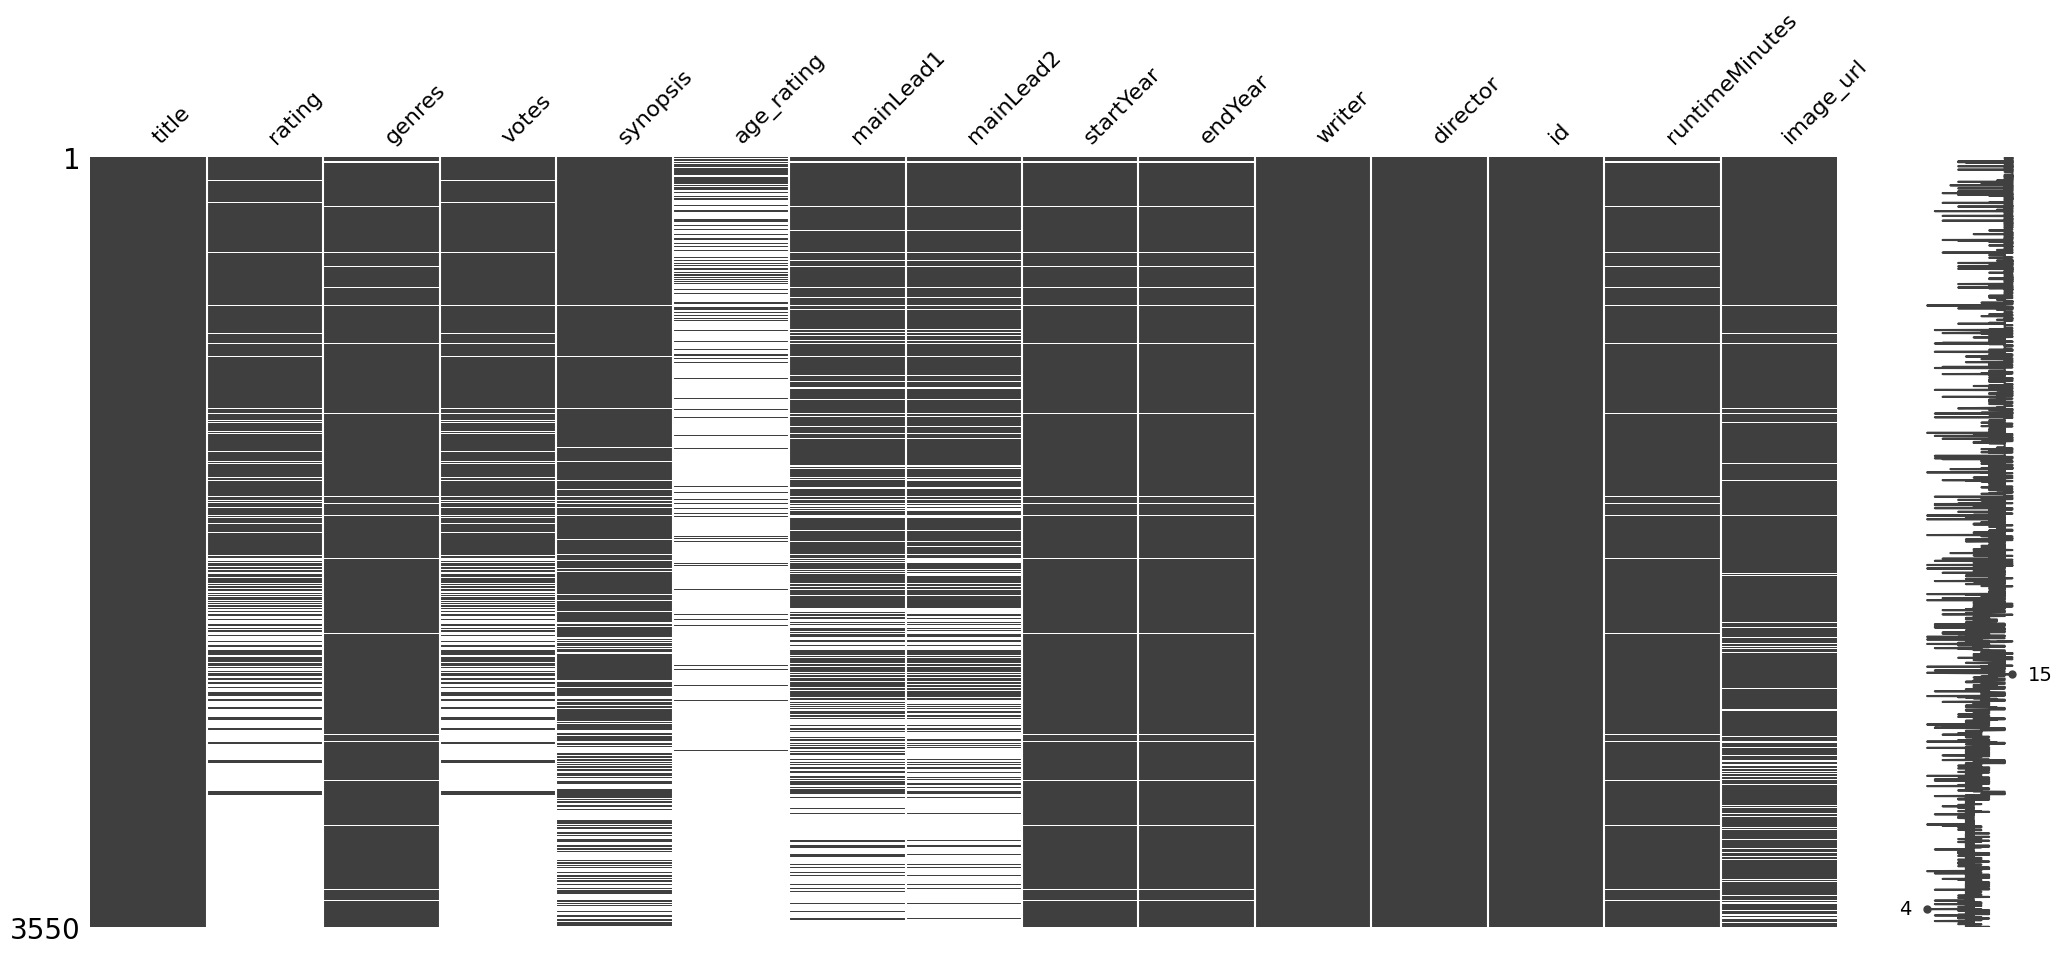

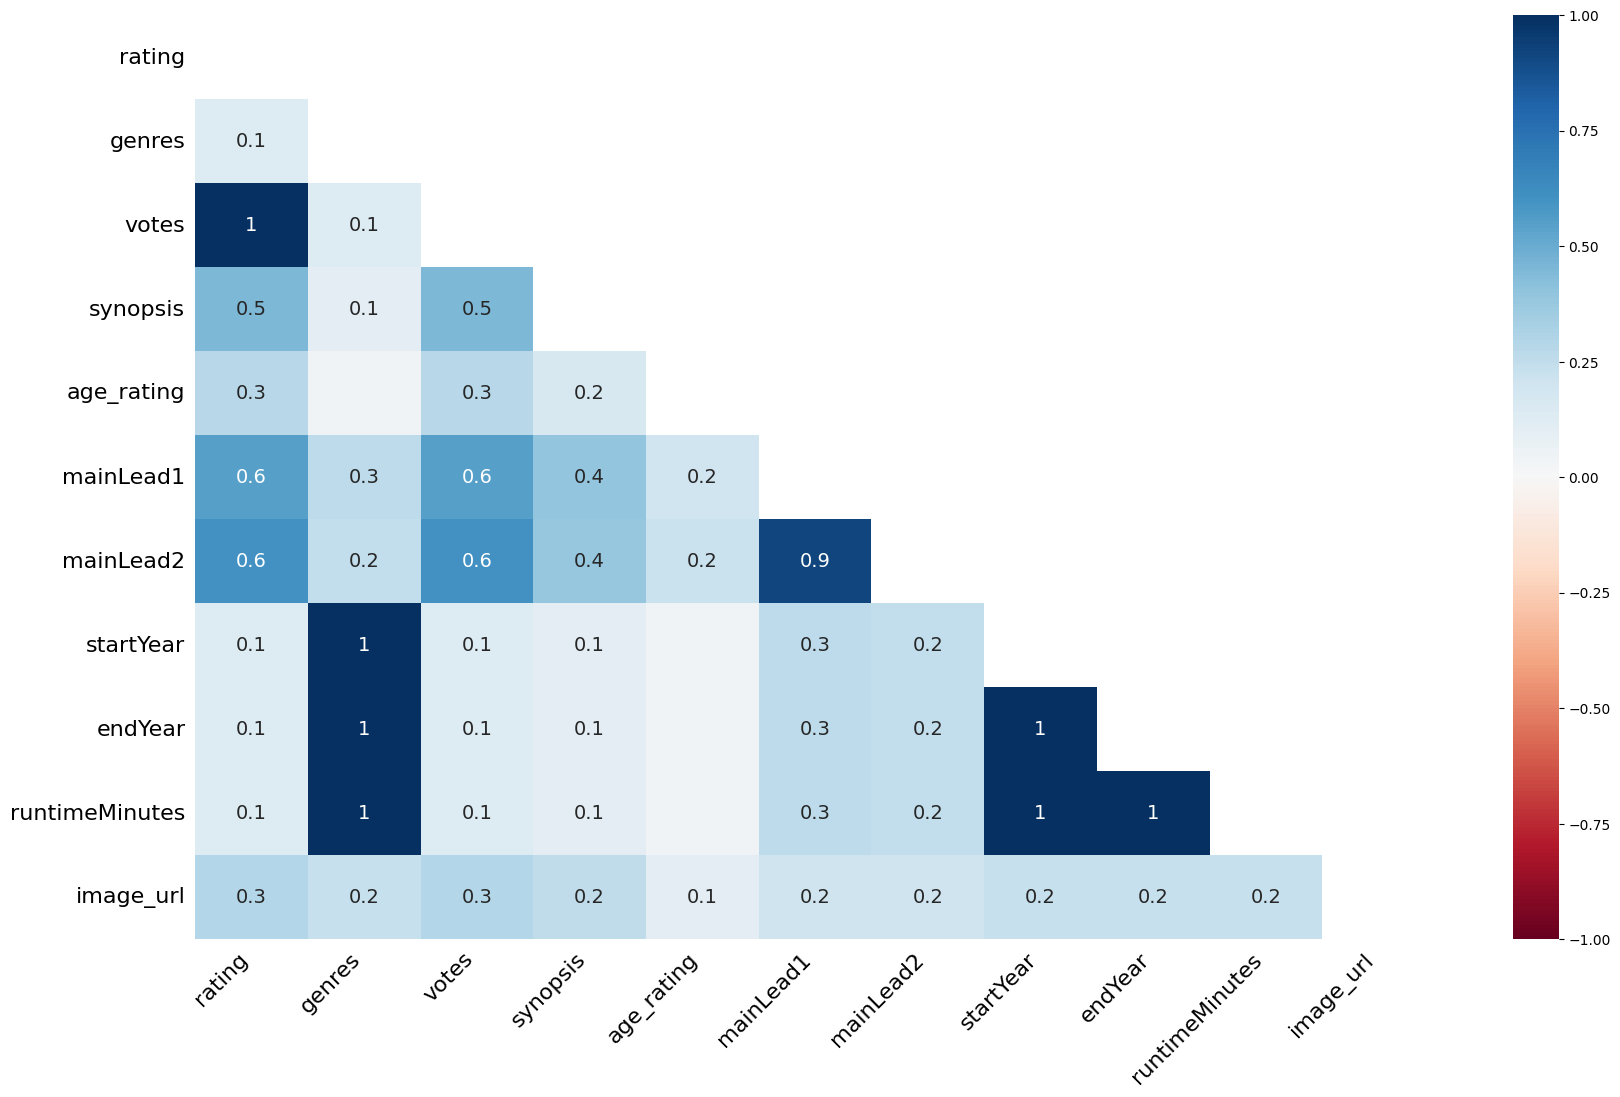

In [3]:
# Visualize missing data (optional)
msno.matrix(df)
msno.heatmap(df)

Handle missing values

In [7]:
num_means = df.select_dtypes(include=['number']).mean()
df_filled = df.fillna(num_means)

Handle outliers

In [9]:
# Handle outliers safely
from scipy import stats

# Compute z-scores on numeric columns only
numeric_df = df_filled.select_dtypes(include=['number'])
z_scores = np.abs(stats.zscore(numeric_df, nan_policy='omit'))

# Keep rows where all numeric columns have z-score < 3
mask = (z_scores < 3).all(axis=1)
df_no_outliers = df_filled.loc[mask]

# Cap outliers in 'votes' if the column exists and is numeric
if 'votes' in df_filled.columns and np.issubdtype(df_filled['votes'].dtype, np.number):
    upper_limit = df_filled['votes'].quantile(0.95)
    df_filled['votes'] = np.where(df_filled['votes'] > upper_limit, upper_limit, df_filled['votes'])


Scale and normalize data

In [11]:
numeric_cols = df_filled.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()
scaled_numeric = pd.DataFrame(
    scaler.fit_transform(df_filled[numeric_cols]),
    columns=numeric_cols,
    index=df_filled.index
)
df_scaled = df_filled.copy()
df_scaled[numeric_cols] = scaled_numeric

# Z-score Standardization (numeric columns only, then recombine)
scaler = StandardScaler()
standardized_numeric = pd.DataFrame(
    scaler.fit_transform(df_filled[numeric_cols]),
    columns=numeric_cols,
    index=df_filled.index
)
df_standardized = df_filled.copy()
df_standardized[numeric_cols] = standardized_numeric

Encode categorical variables

In [13]:
# One-hot encoding for categorical variables
# Use the correct column name and handle missing values
if 'genres' in df_scaled.columns:
    df_encoded = pd.get_dummies(
        df_scaled.assign(genres=df_scaled['genres'].fillna('Unknown')),
        columns=['genres']
    )
elif 'genre' in df_scaled.columns:
    df_encoded = pd.get_dummies(
        df_scaled.assign(genre=df_scaled['genre'].fillna('Unknown')),
        columns=['genre']
    )
else:
    df_encoded = df_scaled.copy()

Save the cleaned and preprocessed data

In [15]:
df_encoded.to_csv('data/cleaned_preprocessed_data.csv', index=False)

print('Data cleaning and preprocessing complete. File saved as cleaned_preprocessed_data.csv')

Data cleaning and preprocessing complete. File saved as cleaned_preprocessed_data.csv


Visualize dataset

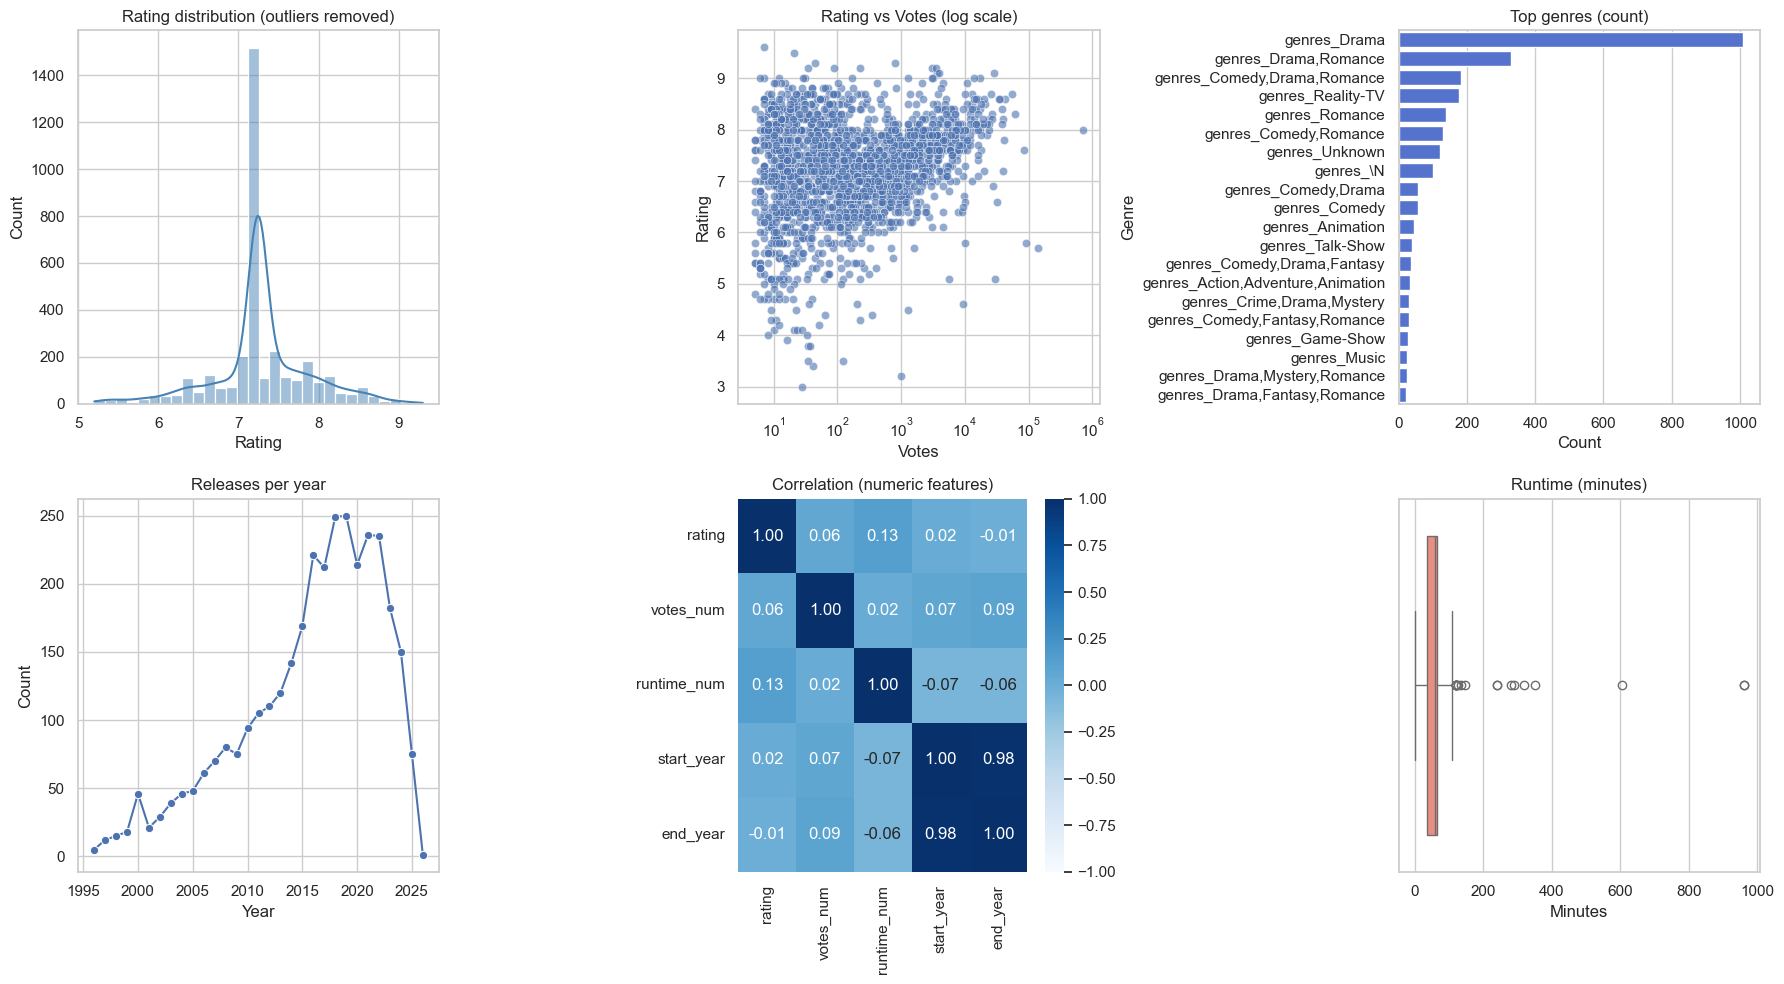

In [ ]:
# Improved visuals
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context='notebook', style='whitegrid', palette='Set2')

def parse_votes(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).strip()
    if s == '' or s == '\\N':
        return np.nan
    mult = 1.0
    if s.endswith('K'):
        mult = 1_000.0
        s = s[:-1]
    elif s.endswith('M'):
        mult = 1_000_000.0
        s = s[:-1]
    try:
        return float(s.replace(',', '')) * mult
    except Exception:
        return np.nan

base = df_filled.copy()
if 'votes' in base.columns:
    base['votes_num'] = base['votes'].apply(parse_votes)
else:
    base['votes_num'] = np.nan
base['runtime_num'] = pd.to_numeric(base.get('runtimeMinutes', np.nan), errors='coerce')
base['start_year'] = pd.to_numeric(base.get('startYear', np.nan), errors='coerce')
base['end_year'] = pd.to_numeric(base.get('endYear', np.nan), errors='coerce')

genre_cols = [c for c in getattr(df_encoded, 'columns', []) if c.startswith('genres_')]
top_genres = pd.Series(dtype=int)
if genre_cols:
    genre_counts = df_encoded[genre_cols].sum().sort_values(ascending=False)
    top_genres = genre_counts.head(15)

year_counts = base['start_year'].dropna().astype(int).value_counts().sort_index()
plot_years = year_counts
if not year_counts.empty:
    recent_threshold = max(year_counts.index.max() - 30, year_counts.index.min())
    plot_years = year_counts[year_counts.index >= recent_threshold]

corr_cols = [c for c in ['rating', 'votes_num', 'runtime_num', 'start_year', 'end_year'] if c in base.columns]
corr = base[corr_cols].corr()

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
fig.suptitle('K-Drama Dataset Overview', fontsize=16, y=1.02)

# 1) Rating distribution
ax = axes[0, 0]
if 'rating' in base.columns:
    sns.histplot(df_no_outliers['rating'].dropna() if 'rating' in df_no_outliers.columns else base['rating'].dropna(),
                 bins=30, kde=True, ax=ax, color='steelblue')
    ax.set_title('Rating distribution')
    ax.set_xlabel('Rating')
else:
    ax.text(0.5, 0.5, 'No rating column', ha='center', va='center')
    ax.axis('off')

# 2) Rating vs Votes (log-scaled votes)
ax = axes[0, 1]
scatter_df = base[['rating', 'votes_num']].dropna() if {'rating', 'votes_num'}.issubset(base.columns) else pd.DataFrame()
if not scatter_df.empty:
    sns.scatterplot(data=scatter_df, x='votes_num', y='rating', ax=ax, alpha=0.6)
    ax.set_xscale('log')
    ax.set_title('Rating vs Votes (log scale)')
    ax.set_xlabel('Votes')
    ax.set_ylabel('Rating')
else:
    ax.text(0.5, 0.5, 'Not enough data', ha='center', va='center')
    ax.axis('off')

# 3) Top genres
ax = axes[0, 2]
if not top_genres.empty:
    sns.barplot(x=top_genres.values, y=top_genres.index, ax=ax, orient='h', color='royalblue')
    for i, v in enumerate(top_genres.values):
        ax.text(v + (top_genres.values.max() * 0.01), i, int(v), va='center', fontsize=9)
    ax.set_title('Top genres (count)')
    ax.set_xlabel('Count')
    ax.set_ylabel('Genre')
else:
    ax.text(0.5, 0.5, 'No genre columns', ha='center', va='center')
    ax.axis('off')

# 4) Releases per year (recent)
ax = axes[1, 0]
if not plot_years.empty:
    sns.lineplot(x=plot_years.index, y=plot_years.values, ax=ax, marker='o')
    ax.set_title('Releases per year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
else:
    ax.text(0.5, 0.5, 'No year data', ha='center', va='center')
    ax.axis('off')

# 5) Correlation heatmap
ax = axes[1, 1]
if not corr.empty:
    sns.heatmap(corr, annot=True, cmap='Blues', ax=ax, vmin=-1, vmax=1, fmt='.2f')
    ax.set_title('Correlation (numeric features)')
else:
    ax.text(0.5, 0.5, 'No numeric correlation', ha='center', va='center')
    ax.axis('off')

# 6) Runtime distribution
ax = axes[1, 2]
if 'runtime_num' in base.columns and base['runtime_num'].notna().any():
    sns.boxplot(x=base['runtime_num'], ax=ax, color='salmon')
    ax.set_title('Runtime (minutes)')
    ax.set_xlabel('Minutes')
else:
    ax.text(0.5, 0.5, 'No runtime data', ha='center', va='center')
    ax.axis('off')

sns.despine()
plt.tight_layout()
plt.show()

Automate the workflow (optional)

In [ ]:
def load_data(filepath):
    return pd.read_csv(filepath)

def handle_missing_values(df):
    return df.fillna(df.mean())

def remove_outliers(df):
    z_scores = np.abs(stats.zscore(df))
    return df[(z_scores < 3).all(axis=1)]

def scale_data(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

def encode_categorical(df, categorical_columns):
    return pd.get_dummies(df, columns=categorical_columns)

def save_data(df, output_filepath):
    df.to_csv(output_filepath, index=False)

# Example usage:
df = load_data('your_dataset.csv')
df = handle_missing_values(df)
df = remove_outliers(df)
df = scale_data(df)
df = encode_categorical(df, ['categorical_column_name'])
save_data(df, 'cleaned_preprocessed_data.csv')